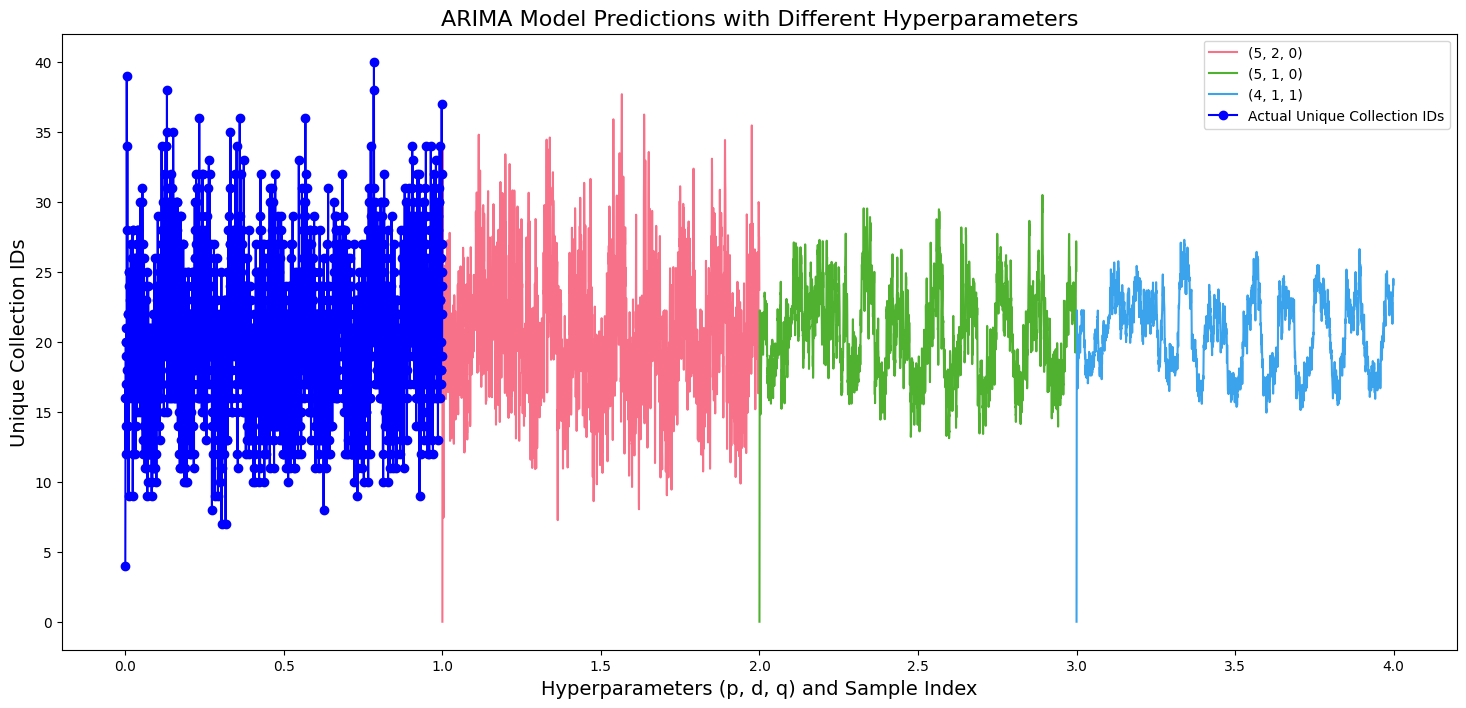

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA

# Load Dataset extracted from BigQuery
file_path = "/home/nsmsc/merged_instance_usage_200k - new.csv"
data = pd.read_csv(file_path)

# Convert start and end times from microseconds to seconds
data['start_time'] = data['start_time'] / 1e6
data['end_time'] = data['end_time'] / 1e6

# Sort data by start time
data = data.sort_values(by='start_time')

# Define the interval length 
interval_length = 300

def process_interval(interval_data):
    collection_id_counts = interval_data['collection_id'].value_counts()
    non_unique_collection_ids_count = collection_id_counts[collection_id_counts > 1].count()
    unique_collection_ids_count = interval_data['collection_id'].nunique()
    unique_machine_ids_count = interval_data['machine_id'].nunique()
    sum_avg_cpu = interval_data['average_usage.cpus'].sum()
    sum_avg_memory = interval_data['average_usage.memory'].sum()
    sum_max_cpu = interval_data['maximum_usage.cpus'].sum()
    sum_max_memory = interval_data['maximum_usage.memory'].sum()
    return {
        'unique_collection_ids': unique_collection_ids_count,
        'non_unique_collection_ids': non_unique_collection_ids_count,
        'unique_machine_ids': unique_machine_ids_count,
        'sum_avg_cpu': sum_avg_cpu,
        'sum_avg_memory': sum_avg_memory,
        'sum_max_cpu': sum_max_cpu,
        'sum_max_memory': sum_max_memory
    }

def create_interval_features(df):
    start_time = df['start_time'].min()
    end_time = df['start_time'].max()
    current_start = start_time
    results = []
    while current_start < end_time:
        current_end = current_start + interval_length
        interval_data = df[(df['start_time'] >= current_start) & (df['start_time'] < current_end)]
        if not interval_data.empty:
            interval_result = process_interval(interval_data)
            interval_result['interval_start'] = current_start
            interval_result['interval_end'] = current_end
            results.append(interval_result)
        current_start = current_end
    return pd.DataFrame(results)

# Split data into training (70%) and testing (30%) sets
train_data, test_data = train_test_split(data, test_size=0.3, shuffle=False)

# Process training data
train_intervals_df = create_interval_features(train_data)

# Prepare the target variable for ARIMA models
train_target = train_intervals_df['unique_collection_ids']

# Train ARIMA models with different hyperparameters
params = [(5, 2, 0), (5, 1, 0), (4, 1, 1)]
models = {}
predictions = {}

for param in params:
    p, d, q = param
    model = ARIMA(train_target, order=(p, d, q)).fit()
    models[param] = model
    predictions[param] = model.predict(start=0, end=len(train_intervals_df)-1)

# Process the testing data into intervals
test_intervals_df = create_interval_features(test_data)

# Prepare the actual values for predictions
actual_values = test_intervals_df['unique_collection_ids']

# Make predictions for the testing intervals using each model
for param in params:
    model = models[param]
    predictions[param] = model.predict(start=0, end=len(test_intervals_df)-1)

plot_data = pd.DataFrame({
    'Parameter': np.concatenate([[str(param)] * len(test_intervals_df) for param in params]),
    'Unique Collection IDs': np.concatenate([predictions[param] for param in params]),
    'Sample Index': np.tile(test_intervals_df.index, len(params))
})

# Adjust the x-axis for visualization (1.0 for first, 2.0 for second, etc.)
plot_data['X'] = plot_data['Parameter'].map({str(params[i]): i + 1 for i in range(len(params))}) + plot_data['Sample Index'] / len(test_intervals_df)

# Plot
plt.figure(figsize=(18, 8))
sns.lineplot(data=plot_data, x='X', y='Unique Collection IDs', hue='Parameter', palette='husl')

# Plot actual values (offset slightly to the left of the first section)
plt.plot(test_intervals_df.index / len(test_intervals_df), actual_values, marker='o', color='blue', label='Actual Unique Collection IDs')

# Set labels and titles
plt.title('ARIMA Model Predictions with Different Hyperparameters', fontsize=16)
plt.xlabel('Hyperparameters (p, d, q) and Sample Index', fontsize=14)
plt.ylabel('Unique Collection IDs', fontsize=14)
plt.legend()
plt.show()


In [6]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import numpy as np


def calculate_metrics(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = mean_absolute_percentage_error(actual, predicted)
    return mae, rmse, mape

# Calculate the metrics 
metrics = {}
for param in params:
    predicted_values = predictions[param]
    mae, rmse, mape = calculate_metrics(actual_values, predicted_values)
    metrics[param] = {
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape
    }

# Display the results
metrics_df = pd.DataFrame(metrics).T
print(metrics_df)


            MAE      RMSE      MAPE
5 2 0  5.023389  6.252689  0.265443
  1 0  4.319118  5.383068  0.231645
4 1 1  4.029186  5.048797  0.217848


In [7]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import numpy as np

# Function to calculate MAE, MSE, RMSE, and MAPE
def calculate_all_metrics(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(actual, predicted)
    return mae, mse, rmse, mape


all_metrics = {}


features = ['unique_collection_ids', 'non_unique_collection_ids', 'unique_machine_ids', 
            'sum_avg_cpu', 'sum_avg_memory', 'sum_max_cpu', 'sum_max_memory']


for feature in features:
    feature_metrics = {}
    

    actual_values = test_intervals_df[feature]
    
   
    for param in params:
        model = models[param]
        predicted_values = model.predict(start=0, end=len(test_intervals_df)-1)
        
        # Calculate metrics
        mae, mse, rmse, mape = calculate_all_metrics(actual_values, predicted_values)
        
      
        feature_metrics[param] = {
            'MAE': mae,
            'MSE': mse,
            'RMSE': rmse,
            'MAPE': mape
        }
    
    # Add the feature's metrics to the main dictionary
    all_metrics[feature] = pd.DataFrame(feature_metrics).T

# Display the results
for feature, metrics_df in all_metrics.items():
    print(f"Metrics for {feature}:\n")
    print(metrics_df)
    print("\n" + "-"*50 + "\n")


Metrics for unique_collection_ids:

            MAE        MSE      RMSE      MAPE
5 2 0  5.023389  39.096121  6.252689  0.265443
  1 0  4.319118  28.977423  5.383068  0.231645
4 1 1  4.029186  25.490355  5.048797  0.217848

--------------------------------------------------

Metrics for non_unique_collection_ids:

             MAE         MSE       RMSE          MAPE
5 2 0  18.760263  374.809313  19.359993  1.562615e+16
  1 0  18.743769  363.371260  19.062299  1.534478e+16
4 1 1  18.731603  359.767274  18.967532  1.524717e+16

--------------------------------------------------

Metrics for unique_machine_ids:

            MAE        MSE      RMSE      MAPE
5 2 0  5.759476  52.700099  7.259483  0.259183
  1 0  5.099310  42.380736  6.510049  0.228300
4 1 1  4.866149  38.787628  6.227971  0.217564

--------------------------------------------------

Metrics for sum_avg_cpu:

             MAE         MSE       RMSE        MAPE
5 2 0  20.464628  439.580775  20.966182  195.650994
  1 0  20.

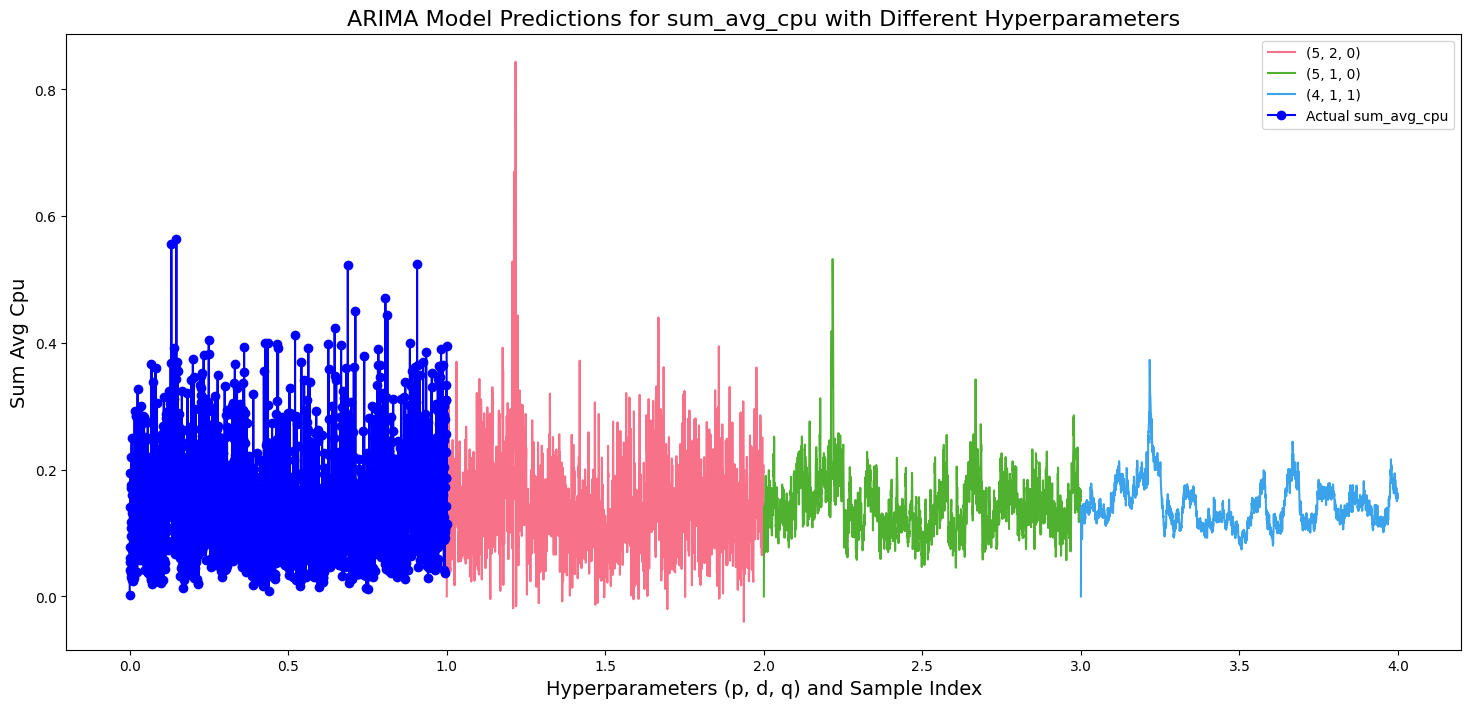

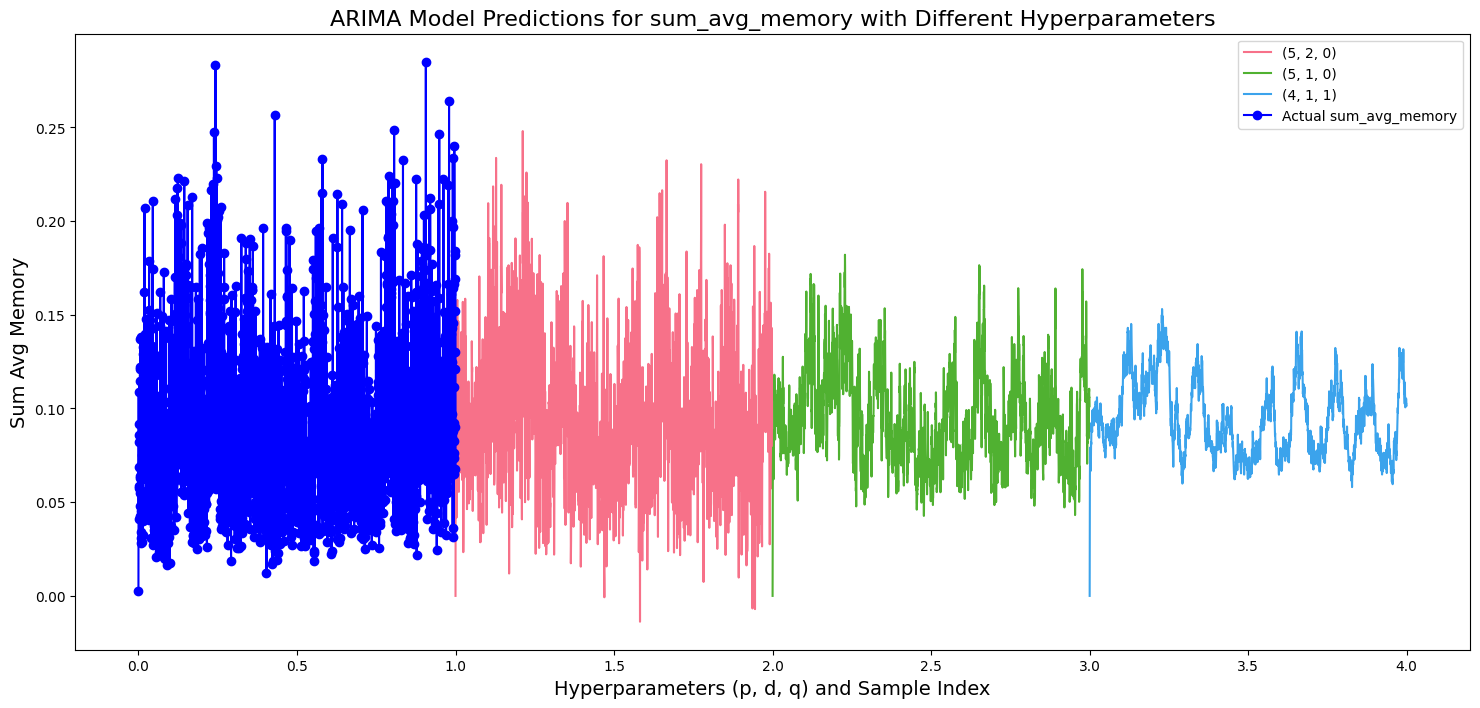

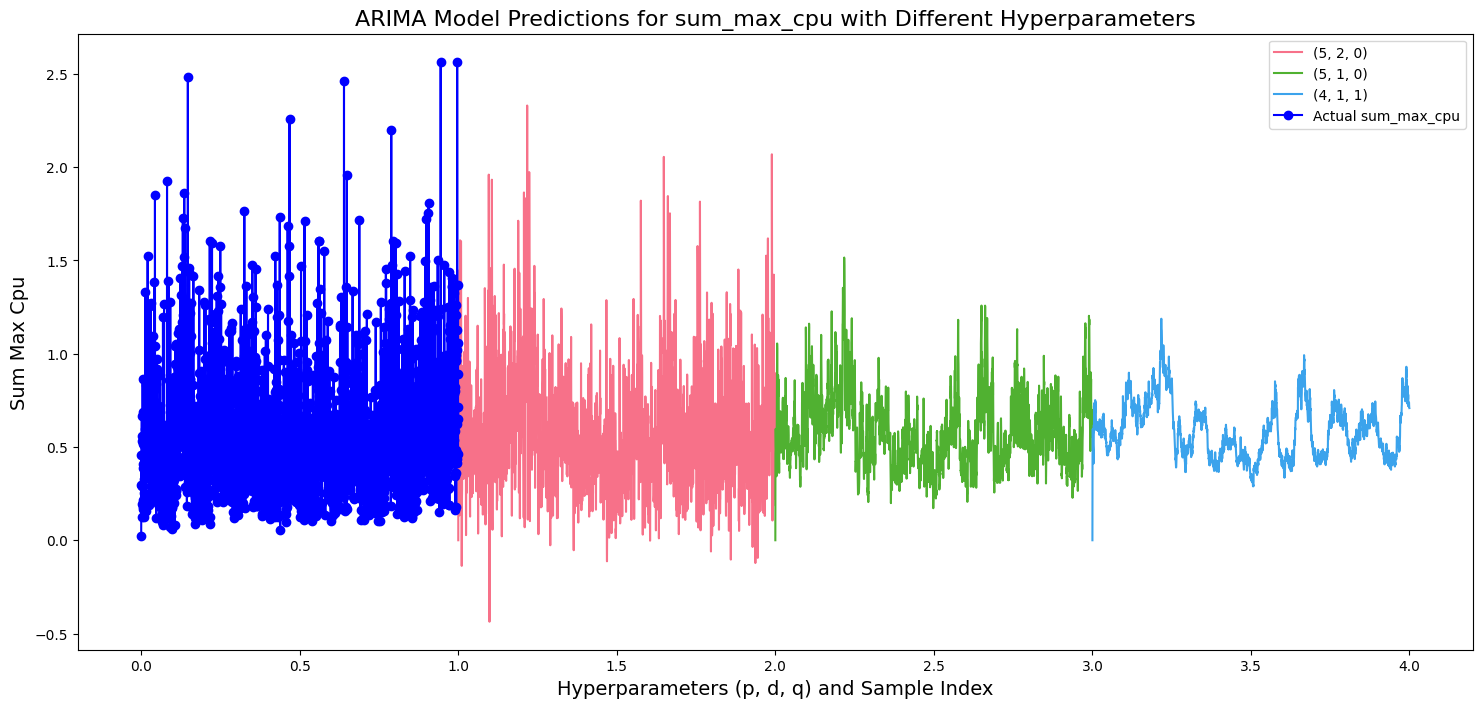

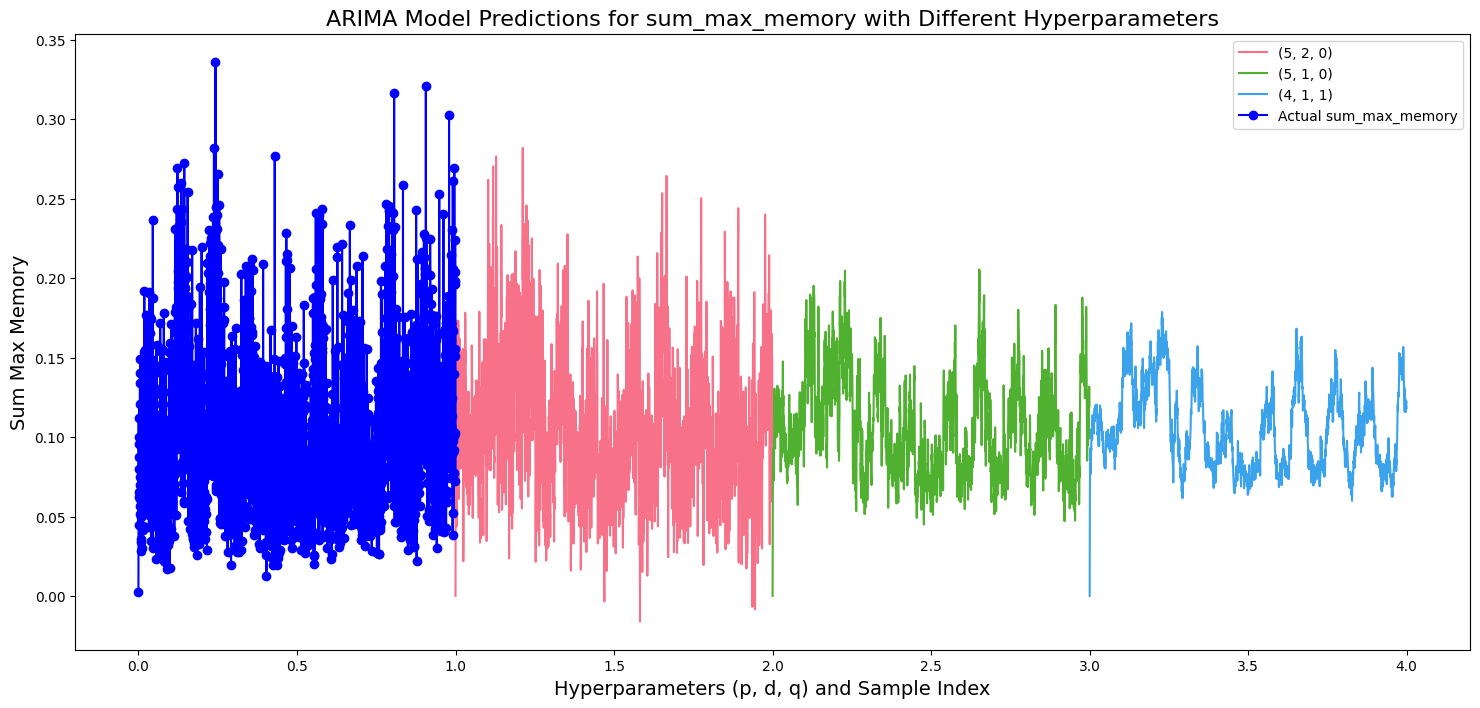

In [8]:
# Prepare the target variables for ARIMA models
target_columns = ['sum_avg_cpu', 'sum_avg_memory', 'sum_max_cpu', 'sum_max_memory']
train_targets = {col: train_intervals_df[col] for col in target_columns}
test_targets = {col: test_intervals_df[col] for col in target_columns}

# Train ARIMA models for each target variable
models = {col: {} for col in target_columns}
predictions = {col: {} for col in target_columns}

for col in target_columns:
    for param in params:
        p, d, q = param
        model = ARIMA(train_targets[col], order=(p, d, q)).fit()
        models[col][param] = model
        predictions[col][param] = model.predict(start=0, end=len(test_intervals_df)-1)

# Plot results for each feature
for col in target_columns:
    # Create a combined DataFrame for horizontal separation
    plot_data = pd.DataFrame({
        'Parameter': np.concatenate([[str(param)] * len(test_intervals_df) for param in params]),
        col: np.concatenate([predictions[col][param] for param in params]),
        'Sample Index': np.tile(test_intervals_df.index, len(params))
    })

   
    plot_data['X'] = plot_data['Parameter'].map({str(params[i]): i + 1 for i in range(len(params))}) + plot_data['Sample Index'] / len(test_intervals_df)

    # Plot
  
    sns.lineplot(data=plot_data, x='X', y=col, hue='Parameter', palette='husl')

   
    plt.plot(test_intervals_df.index / len(test_intervals_df), test_targets[col], marker='o', color='blue', label=f'Actual {col}')

  
    plt.title(f'ARIMA Model Predictions for {col} with Different Hyperparameters', fontsize=16)
    plt.xlabel('Hyperparameters (p, d, q) and Sample Index', fontsize=14)
    plt.ylabel(col.replace('_', ' ').title(), fontsize=14)
    plt.legend()
    plt.show()
